# Exercise: document models
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1819/cw/coursework3.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1819/). This version adapted by Damon Wischik._

This coursework involves aggregating, summarizing, and joining datasets. This may be done with straight Python, or with MATLAB-style manipulations using `numpy`, or with `pandas` dataframes. If you anticipate future work in machine learning and data science then you should learn to use `pandas` dataframes, and you may find it helpful to follow the walkthrough in [Section 3](https://github.com/damonjw/scicomp/blob/master/notes3_pandas.ipynb) of IA _Scientific Computing_. If you prefer not to use dataframes, and you have questions about how they are being used in the code snippets below, ask your classmates or Dr Wischik.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. 
The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two. Marks will be awarded based on the clarity and insight in your explanations.

DO NOT SUBMIT FULL SOURCE CODE, unless it is as an appendix. Do not repeat the question text in your answers. If you submit your answers as a Jupyter notebook, structure the notebook in two sections: a section at the top for the examiner to read with just your answers and trimmed code snippets, and a section at the bottom with all your working code.

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import requests, io
from scipy.special import gamma

pd.set_option("display.max_rows", 200, "display.max_columns", 200)

## Data import

The data is provided as `https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/kos_doc_data.mat`. It contains two matrices $A$ and $B$ for training and testing respectively, both matrices with 3 columns: document ID, word ID, and word count. The words themselves are the vector $V$, where e.g. `V[840]='bush'`. The following snippet reads in the data, and converts $A$ and $B$ to dataframes.

In [6]:
r = requests.get('https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/kos_doc_data.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    V = np.array([i[0] for i in data['V'].squeeze()])
    A,B = [pd.DataFrame({'doc_id': M[:,0]-1, 'word_id': M[:,1]-1, 'count': M[:,2]}, 
                            columns=['doc_id','word_id','count']) 
           for M in (data['A'],data['B'])]

## Question (a): simple categorical model

Suppose we model words in a document as independent samples from a categorical distribution with parameter $\beta$, where $\beta_v$ is the probability of word $v\in V$. Using $A$ as the training set, find the maximum likelihood estimator $\hat{\beta}$, and plot the 20 most-probable words in a histogram. What is the log probability of the test document `doc_id=2527`, given $\hat{\beta}$? Briefly interpret your answer.

Note: you can plot a histogram with
```python
fig,ax = plt.subplots(figsize=(5,8))
ax.barh(np.arange(20), ???, align='center')
ax.set_yticks(np.arange(20))
ax.set_yticklabels(???)
ax.set_xlabel(r'$\hat{\beta}$')
ax.invert_yaxis()
plt.show()
```

The maximum likelihood estimator for the simple categorical model is the empirical word frequency:
$${\hat \beta_m} = \frac {c_m}{\sum_l^M c_l}$$
where $$c_k = \sum_d \sum_n \mathbb{I}(w_{nd} = k)$$
This is implemented below.

In [7]:
vocabulary_size = V.shape[0]
wordcount_entire_collection = A["count"].sum()
beta = np.zeros((vocabulary_size,))

for m in range(vocabulary_size):
    c_m = A[(A.word_id == m)==True]["count"].sum()
    beta[m] = c_m / wordcount_entire_collection

In [49]:
beta_dictionary = dict(zip(range(vocabulary_size), beta))
beta_indices_sorted_ascending = sorted(beta_dictionary, key=lambda k: beta_dictionary[k])

beta[beta_indices_sorted_ascending[-20:]]

array([0.00340937, 0.00342776, 0.00343143, 0.00344615, 0.00352706,
       0.00353441, 0.00384335, 0.00388749, 0.00401989, 0.00432883,
       0.00450537, 0.00468558, 0.00497245, 0.00498716, 0.00534392,
       0.00535863, 0.00570067, 0.00841124, 0.00967642, 0.0140972 ])

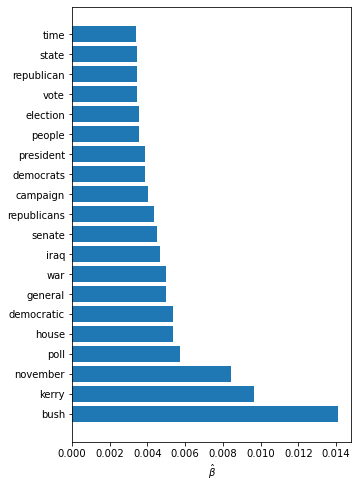

In [50]:
fig, ax = plt.subplots(figsize=(5,8))
ax.barh(np.arange(20), beta[beta_indices_sorted_ascending[-20:]], align='center')
ax.set_yticks(np.arange(20))
ax.set_yticklabels(V[beta_indices_sorted_ascending[-20:]])
ax.set_xlabel(r'$\hat{\beta}$')
ax.invert_yaxis()
plt.show()

To calculate the log-likelihood of the test document `2527`, we would have to calculate the joint probability of its words, which, assuming independence, is:
$$\begin{aligned}
p(w_1, w_2, \dots, w_{n_{2527}}) &= p(w_1)p(w_2) \dots p(w_{n_{2527}}) \\
\log p(w_1, w_2, \dots, w_{n_{2527}}) &= \log p(w_1) + \log p(w_2) + \dots + \log p(w_{n_{2527}})
\end{aligned}$$
Unfortunately, we can't do this—the log-likelihood for this document is undefined. This is because one of the words in this test document, "schwarz," has not been encountered in any training document. Its probability $\beta_{\text{schwarz}}$ is estimated to be 0, so when we compute the above, we end up having to take the logarithm of 0, which is undefined.

In [120]:
print(f"""The probability of word: {V[5479]} as estimated using MLE is: {beta[5479]}"
This word is not in any training documents:
{A[A["word_id"]==5479]}
This word is in our test document: 
{B[B.doc_id==2527].loc[54865]}""")

The probability of word: schwarz as estimated using MLE is: 0.0"
This word is not in any training documents:
Empty DataFrame
Columns: [doc_id, word_id, count]
Index: []
This word is in our test document: 
doc_id     2527
word_id    5479
count         1
Name: 54865, dtype: uint16


This is a limitation of our model: any words in the holdout set that we haven't seen in the training set are considered to have probability 0. (As far as the model is concerned, these words can't occur at all.) An improvement could be adding a placeholder word, usually `<UNK>`, to our training documents in $A$. The idea is to achieve a non-zero probability for words which do not occur in the training set. We then use this `<UNK>` token's probability instead of the probability of words in the test set, like "schwarz", which we haven't seen. This isn't ideal, but it allows us to compute at least some approximation of the log-likelihood of such a test document.

## Question (b): Bayesian inference

For the categorical model in part (a), use Bayesian inference to find the posterior distribution of $\beta$ given the training set $A$, using a symmetric Dirichlet distribution with concentration parameter $\alpha=0.1$ as prior. Let $\tilde{\beta}_v$ be the posterior predictive probability of word $v\in V$, i.e. the posterior probability that a newly chosen word is $v$. Derive an expression for $\tilde{\beta}_v$, and compare it to $\hat{\beta}_v$. Explain the implications, both for common and for rare words.

Hint: $\Gamma(z+1)=z\,\Gamma(z)$.

Let's denote the posterior probability that a newly chosen word as $\text{Pr}_{W_*}(v | W=w)$. Then:
$$\begin{aligned}
\text{Pr}_{W_*}(v | W=w) &= \int_\beta \text{Pr}_{W_*}(v|W=w, B=\beta) \cdot Pr_B(\beta | W = w) d\beta \\
&= \int_\beta \beta_v \cdot \kappa \cdot\text{Pr}_B(\beta) \text{Pr}_W(w | B=\beta) d\beta \\
&= \int_\beta \beta_v \cdot \kappa \cdot \frac{\Gamma(M\alpha)}{\Gamma^M(\alpha)} \prod_{m=1}^M \beta_m^{\alpha-1} \cdot \prod_{m=1}^M \beta^{c_m} d\beta \\ 
&= \int_\beta \beta_v \cdot \kappa' \cdot \frac{\Gamma(c_1+c_2+\dots+c_M+M\alpha)}{\Gamma(c_1+\alpha)\Gamma(c_2+\alpha)\dots\Gamma(c_M+\alpha)} \prod_{m=1}^M \beta_m^{c_m+\alpha-1} d\beta \\
&= \int_\beta \beta_v \cdot \text{Dir}(c_1+\alpha, c_2+\alpha, \dots, c_M+\alpha) d\beta \\
&= \mathbb{E}_{\text{Dir}(c_1+\alpha, c_2+\alpha, \dots, c_M+\alpha)}[\beta_v] = \frac{\alpha + c_v}
{\sum_{m=1}^M \alpha + c_m}
\end{aligned}$$

This result makes sense! It is almost the same as the maximum likelihood estimator $\hat \beta_v$, with the distinction that the posterior predictive takes into account $\alpha$, which plays the role of pseudo-count. We started with a symmetric Dirichlet prior, which meant that all words had equal pseudo-counts; it's an unbiased prior, which doesn't favour any word over another, and instead lets the data do the 'convincing'. For common words, we expect $c_v >> \alpha$, which seems like the 'rich get richer' idea from the lecture materials: the more often a word was encountered in the data, the more likely we are to predict it. For rare words, the posterior predictive probability is still 'lower bound' by $\alpha$, which means we wouldn't have a situation where the probability of predicting a previously unseen word is 0 — the situation we had in (a).

## Question (c): interpretation

The log likelihood $\log p(w)$ of a document $w$ depends on the number of words in the document, and it's more useful to report the log likelihood per word, $n^{-1}\log p(w)$ where $n$ is the number of words in $w$. 

(In information theory, $-n^{-1}\log_2 p(w)$ can be interpreted as the number of bits per word needed to encode or transmit $w$. In text modelling, it is more common to report _per-word perplexity_ $p(w)^{-1/n}$.)

For the trained Bayesian model from part (b), what is the per-word log likelihood of the test document `doc_id=2000`? Plot a histogram showing the distribution of per-word log likelihood over all the test documents (using [`plt.hist`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html?highlight=matplotlib%20pyplot%20hist#matplotlib.pyplot.hist)). Pick out two documents, one with high per-word perplexity and one with low per-word perplexity, show their contents, and interpret the difference between them.

In [81]:
def per_word_perplexity(p_w, n):
    # Make sure we don't try to take log 0.
    return -np.log2(p_w)/n if p_w > 0 else 0

def per_word_likelihood(p_w, n):
    return np.log(p_w)/n if p_w > 0 else 0

In [61]:
alpha = 0.1

# Implement the posterior predictive we got in (b).
betas = np.zeros(vocabulary_size)
for i in range(vocabulary_size):
    betas[i] = (A[A.word_id == i]["count"].sum() + alpha) / (vocabulary_size*alpha + wordcount_entire_collection)

In [83]:
unique_test_docs = np.unique(B.doc_id.values)
document_likelihoods = {}

# For each document d in the test set,
for doc in unique_test_docs:
    Pr = 1
    doc_df = B[B.doc_id==doc]
    
    # For each word in document d, multiply the β_v with the other words β_w
    for word in doc_df.word_id.values:
        Pr *= betas[word] ** doc_df[doc_df.word_id==word]["count"].values[0]
        
    # Store the likelihood.
    document_likelihoods[doc] = Pr

The per-word log likelihood of document `doc_id=2000` is 0. This is because the log likelihood across the entire document is very very close to 0, and due to numerical precision limitations it is approximated as 0. `doc_id=2000` contains a large number of words relative to other documents:

In [94]:
c_2000 = B[B.doc_id==2000]["count"].sum()
c_2001 = B[B.doc_id==2001]["count"].sum()
print(f"For doc_id=2000, per-word log likelihood is: {per_word_likelihoods[2000]}. It contains: {c_2000} words.")
print(f"For doc_id=2001, per-word log likelihood is: {per_word_likelihoods[2001]}. It contains: {c_2001} words.")

For doc_id=2000, per-word log likelihood is: 0. It contains: 440 words.
For doc_id=2001, per-word log likelihood is: -8.233012252255577. It contains: 39 words.


In [95]:
# Compute per-word likelihoods and perplexities.
per_word_likelihoods = dict([(i, per_word_likelihood(document_likelihoods[i], B[B.doc_id==i]["count"].sum())) for i in document_likelihoods.keys()])
per_word_perplexities = dict([(i, per_word_perplexity(document_likelihoods[i], B[B.doc_id==i]["count"].sum())) for i in document_likelihoods.keys()])

In the histogram below, the document labels are omitted — there are 1430 of them. What is interesting about this visualisation is that there are gaps in the histogram, documents that are large enough that their per-word log likelihood is very close to 0, and so approximates to 0.

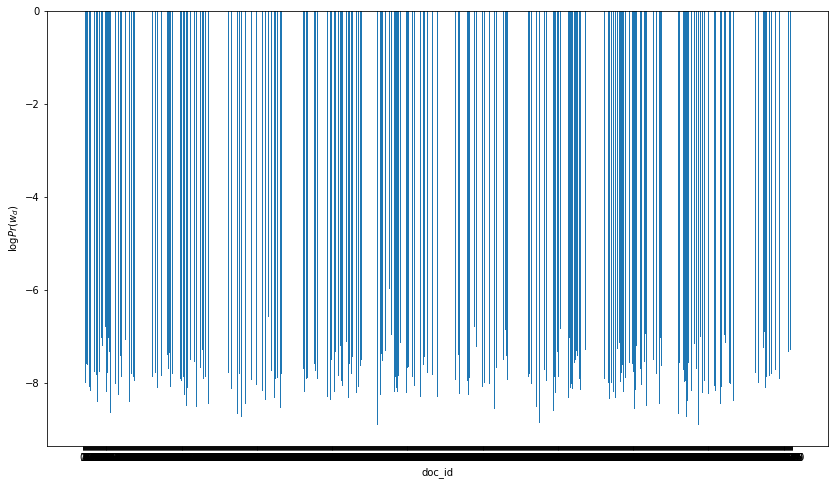

In [109]:
# Plot histogram of test document per-word log-Pr.
fig, ax = plt.subplots(figsize=(14,8))

# Distinct number of documents in B
ax.bar(np.arange(len(per_word_likelihoods)), per_word_likelihoods.values(), align='center')
ax.set_xticks(np.arange(len(per_word_likelihoods)))
ax.set_xlabel("doc_id")
ax.set_ylabel(r'$\log Pr(w_d)$')
plt.show()

In [114]:
count_likelihoods = {}
for (doc_id, logPr) in per_word_likelihoods.items():
    cts = B[B.doc_id==doc_id]["count"].sum()
    if cts not in count_likelihoods:
        count_likelihoods[cts] = logPr
    else:
        count_likelihoods[cts] += logPr

In [117]:
ax.bar(np.arange(len(count_likelihoods)), count_likelihoods.values(), align='center')
ax.set_xticks(np.arange(len(count_likelihoods)))
ax.set_xlabel("document length")
ax.set_ylabel(r'$\log Pr(w_d)$')
plt.show()

## Question (d): Gibbs sampler for the mixture-of-multinomials model

The Bayesian mixture-of-multinomials model can be described by the following code:

In [4]:
def bmm_generate(doc_length, V, α, γ, K):
    # doc_length = [num words in doc1, num words in doc2, ...]
    θ = np.random.dirichlet(α * np.ones(K))              # prob dist over document classes {1,...,K}
    β = np.random.dirichlet(γ * np.ones(len(V)), size=K) # for each doc class, a prob dist over words
    z = np.random.choice(K, p=θ, size=len(doc_length))   # doc class of each document
    return [np.random.choice(V, p=β[zd], size=nd) for zd,nd in zip(z, doc_length)]

for doc in bmm_generate(doc_length=[5,2,4], V=V, α=10, γ=.1, K=20):
    print(doc)

['critic' 'indymedia' 'susan' 'citizenship' 'cycles']
['cool' 'celebrity']
['jennings' 'quarter' 'token' 'governance']


The following code implements a collapsed Gibbs sampler. Complete the line that defines `logp`. In each sweep, the Gibbs sampler produces a sample of document classes, and this sample induces a posterior predictive distribution for the probability of each class. Plot how this distribution evolves as a function of the number of Gibbs sweeps. How many iterations does it take to converge?

The Gibbs sampler may be run as follows:

In [1]:
def bmm_gibbs(doc_label, word_id, count, W, α, γ, K):
    """word_id : Series of word_ids
       count : Series of counts
       doc_label : Series of document IDs
    """
    # doc_labels = distinct values of doc_label
    # doc_index = a list as long as doc_label
    #             such that doc_labels[doc_index[j]] = doc_label[j]
    doc_labels, doc_index = np.unique(doc_label, return_inverse=True)

    # z[i] = class of document i, where i enumerates the distinct doc_labels
    # doc_count[k] = number of documents of class k
    z = np.random.choice(K, len(doc_labels))
    doc_count = np.zeros(K, dtype=int)
    for k in z: doc_count[k] += 1

    # A DataFrame indexed by document class that is used to count occurrences
    # of each word in documents of class k.
    x = pandas.DataFrame({'doc_class': z[doc_index], 'word_id': word_id, 'count': count}) \
        .groupby(['doc_class', 'word_id']) \
        ['count'].apply(sum) \
        .unstack(fill_value=0)
    
    # occurrences[k,w] = number of occurrences of word_id w in documents of class k
    occurrences = np.zeros((K, len(V)))
    occurrences[x.index.values.reshape((-1,1)), x.columns.values] = x
    
    # word_count[k] = total number of words in documents of class k
    word_count = np.sum(occurrences, axis=1)
    
    while True:
        for i in range(len(doc_labels)):

            # Get the words, counts for document i
            # and remove this document from the counts.
            # Why remove?
            w,c = word_id[doc_index==i].values, count[doc_index==i].values
            occurrences[z[i], w] -= c
            word_count[z[i]] -= sum(c)
            doc_count[z[i]] -= 1

            # Find the log probability that this document belongs to class k, marginalized over θ and β
            logp = [... for k in range(K)]
            p = np.exp(logp - np.max(logp)) # Why do we do this? Is it to renormalise?
            p = p/sum(p)

            # Assign this document to a new class, chosen randomly, and add back the counts
            k = np.random.choice(K, p=p)
            z[i] = k
            occurrences[k, w] += c
            word_count[k] += sum(c)
            doc_count[k] += 1
        
        yield np.copy(z)

In [ ]:
g = bmm_gibbs(A['doc_id'], A['word_id'], A['count'], W=len(V), α=10, γ=.1, K=20)
NUM_ITERATIONS = 20
res = np.stack([next(g) for _ in range(NUM_ITERATIONS)])
# this produces a matrix with one row per iteration and a column for each unique doc_id

## Question (e): interpretation

Let $\alpha=10$, $\gamma=0.1$, $K=20$. Run the Gibbs sampler until it converges, and find the posterior predictive probabilities for topics, and for words within each topic. 
For each the 8 most popular topics, print the probability of the topic and the 8 most probable words and their probabilities.
Display probabilities in _shannons_, i.e. display a probability $p$ as $-\log_2 p$. An increase of 1 shannon corresponds to a 50% decrease in probability.

Rerun with different random seeds. Do you think this method has succeeded in identifying topics?

There are some words that are very common across all topics. Find the _distinctive_ words for each topic. _[This is open-ended, and it's up to you to invent your own answer. Don't overthing it, and don't write more than a paragraph justifying your choice.]_

## Question (f): evaluation

Give a formula for per-word log likelihood for the mixture model, in terms of the posterior predictive probabilities for topics and words.

Plot a histogram showing the distribution of per-word log likelihood over all the test documents for the model in part (e). Also plot the histogram obtained from $K=8$, and the histogram from the plain multinomial model in part (c). Which model do you prefer, and why?